In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [2]:
from floris import tools as wfct
from floris.utilities import wrap_360
from floris_scada_analysis.energy_ratio import energy_ratio
from floris_scada_analysis.dataframe_operations import \
    dataframe_manipulations as dfm
from floris_scada_analysis import floris_tools as fsatools

In [3]:
# Slight mod for jupyter
def load_data():
    # Load dataframe with scada data
    root_dir = os.path.abspath('')
    ftr_path = os.path.join(root_dir, '..', 'demo_dataset',
                            'demo_dataset_60s.ftr')
    if not os.path.exists(ftr_path):
        raise FileNotFoundError('Please run ./examples_artificial_data/demo_dataset/' +
                                'generate_demo_dataset.py before try' +
                                'ing any of the other examples.')
    df = pd.read_feather(ftr_path)
    return df

In [4]:
def load_floris():
    # Initialize the FLORIS interface fi
    print('Initializing the FLORIS object for our demo wind farm')
    file_path = os.path.abspath('')
    fi_path = os.path.join(file_path, "../demo_dataset/demo_floris_input.json")
    fi = wfct.floris_interface.FlorisInterface(fi_path)
    return fi

## Load data and FLORIS

In [5]:
df = load_data()
fi = load_floris()

Initializing the FLORIS object for our demo wind farm


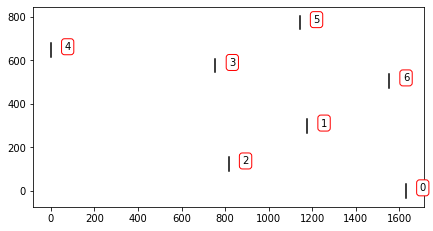

In [6]:
# Visualize layout
fi.vis_layout()

floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.


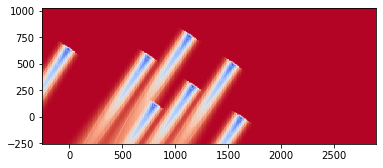

In [7]:
fi.reinitialize_flow_field(wind_direction=34)
fi.calculate_wake()
hor_plane = fi.get_hor_plane()

# Plot and show
fig, ax = plt.subplots()
wfct.visualization.visualize_cut_plane(hor_plane, ax=ax)
plt.show()


In [8]:
## Whats in df
df.head()

,time,wd_truth,ws_truth,ti_truth,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,...,ws_004,ws_005,ws_006,ti_000,ti_001,ti_002,ti_003,ti_004,ti_005,ti_006
0,2019-01-01 00:00:00+00:00,93.1,2.183,0.050,6.405615,6.100646,1.257034,0.000000,0.000000,6.341335,...,1.901380,1.883518,1.964105,0.045674,0.065156,0.121497,0.110181,0.121461,0.042844,0.045657
1,2019-01-01 00:01:00+00:00,92.4,2.240,0.043,8.943440,8.716818,2.311063,0.021222,0.236148,8.592710,...,1.215196,1.869358,2.195737,0.041209,0.061260,0.114905,0.105966,0.123999,0.051384,0.019497
2,2019-01-01 00:02:00+00:00,94.1,1.811,0.094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.388011,1.881638,2.126305,0.083241,0.090032,0.138258,0.159092,0.172953,0.085100,0.086458
3,2019-01-01 00:03:00+00:00,94.3,1.949,0.046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.282829,1.502074,2.005686,0.052539,0.042878,0.116875,0.102517,0.129676,0.059195,0.051452
4,2019-01-01 00:04:00+00:00,97.8,1.773,0.058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.646599,1.781714,1.724378,0.062023,0.073994,0.106133,0.110173,0.120932,0.052493,0.073322


In [9]:
# We first need to define a wd against which we plot the energy ratios
# In this example, we set the wind direction to be equal to the mean
# wind direction between all turbines
df = dfm.set_wd_by_all_turbines(df)
df.head()

/Users/pfleming/Desktop/git_tools/floris_scada_analysis/floris_scada_analysis/dataframe_operations/dataframe_manipulations.py:64: RuntimeWarning: Mean of empty slice
  dir_x = np.nanmean(np.cos(array * np.pi / 180.), axis=1)
/Users/pfleming/Desktop/git_tools/floris_scada_analysis/floris_scada_analysis/dataframe_operations/dataframe_manipulations.py:65: RuntimeWarning: Mean of empty slice
  dir_y = np.nanmean(np.sin(array * np.pi / 180.), axis=1)


,time,wd_truth,ws_truth,ti_truth,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,...,ws_005,ws_006,ti_000,ti_001,ti_002,ti_003,ti_004,ti_005,ti_006,wd
0,2019-01-01 00:00:00+00:00,93.1,2.183,0.050,6.405615,6.100646,1.257034,0.000000,0.000000,6.341335,...,1.883518,1.964105,0.045674,0.065156,0.121497,0.110181,0.121461,0.042844,0.045657,103.218510
1,2019-01-01 00:01:00+00:00,92.4,2.240,0.043,8.943440,8.716818,2.311063,0.021222,0.236148,8.592710,...,1.869358,2.195737,0.041209,0.061260,0.114905,0.105966,0.123999,0.051384,0.019497,104.254322
2,2019-01-01 00:02:00+00:00,94.1,1.811,0.094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.881638,2.126305,0.083241,0.090032,0.138258,0.159092,0.172953,0.085100,0.086458,104.999850
3,2019-01-01 00:03:00+00:00,94.3,1.949,0.046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.502074,2.005686,0.052539,0.042878,0.116875,0.102517,0.129676,0.059195,0.051452,104.670147
4,2019-01-01 00:04:00+00:00,97.8,1.773,0.058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.781714,1.724378,0.062023,0.073994,0.106133,0.110173,0.120932,0.052493,0.073322,106.481094


In [10]:
# We reduce the dataframe to only data where the wind direction
# is between 20 and 40 degrees.
df = dfm.filter_df_by_wd(df=df, wd_range=[0., 90.])
df = df.reset_index(drop=True)

In [11]:
# We also need to define a reference wind speed and a reference power
# production against to normalize the energy ratios with. In this
# example, we set the wind speed equal to the mean wind speed
# of all upstream turbines. The upstream turbines are automatically
# derived from the turbine layout and the wind direction signal in
# the dataframe, df['wd']. The reference power production is set
# as the average power production of turbines 0 and 6, which are
# always upstream for wind directions between 20 and 90 deg.
df_upstream = fsatools.get_upstream_turbs_floris(fi)
df_upstream.head()

,wd_min,wd_max,turbines
0,0.0,18.7,"[3, 4, 5, 6]"
1,18.7,24.9,"[0, 3, 4, 5, 6]"
2,24.9,29.5,"[0, 1, 3, 4, 5, 6]"
3,29.5,31.6,"[0, 3, 4, 5, 6]"
4,31.6,68.7,"[0, 4, 5, 6]"


In [12]:
# Set the wind speed, power and ti using the upstream turbines
df = dfm.set_ws_by_upstream_turbines(df, df_upstream)
df = dfm.set_pow_ref_by_upstream_turbines(df, df_upstream)
df = dfm.set_ti_by_upstream_turbines(df, df_upstream)

df.tail()

,time,wd_truth,ws_truth,ti_truth,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,...,ti_001,ti_002,ti_003,ti_004,ti_005,ti_006,wd,ws,pow_ref,ti
103134,2020-01-01 09:58:00+00:00,36.830,4.072,0.171,179.487100,172.114498,155.113492,184.476420,183.661942,178.000983,...,0.153134,0.188407,0.174582,0.149723,0.188462,0.163168,46.437582,3.945336,182.233143,0.168726
103135,2020-01-01 09:59:00+00:00,46.750,3.355,0.107,85.541799,59.473418,69.859286,67.692755,86.403789,83.612627,...,0.173183,0.174284,0.128537,0.091254,0.092969,0.101029,55.334246,3.311133,84.462373,0.097004
103136,2020-01-01 10:00:00+00:00,64.950,3.005,0.153,35.495015,0.154361,0.156922,0.131472,38.480190,36.430931,...,0.229483,0.223041,0.218451,0.160752,0.156514,0.145334,74.838451,2.834497,36.592800,0.152100
103137,2020-01-01 10:01:00+00:00,29.750,2.942,0.184,34.116622,34.149731,9.454139,33.109244,33.247985,35.267212,...,0.176900,0.233960,0.169642,0.186052,0.179796,0.182584,37.989847,2.854710,34.309218,0.188626
103138,2020-01-01 12:53:00+00:00,3.467,4.758,0.108,268.593801,145.789712,229.565086,334.750697,327.546184,341.128895,...,0.171909,0.168392,0.105062,0.109682,0.116179,0.108950,9.979899,4.805228,336.444445,0.109968


In [13]:
# # Initialize energy ratio object for the dataframe
era = energy_ratio.energy_ratio(df_in=df, verbose=True)

Calculating energy ratios with N = 1.


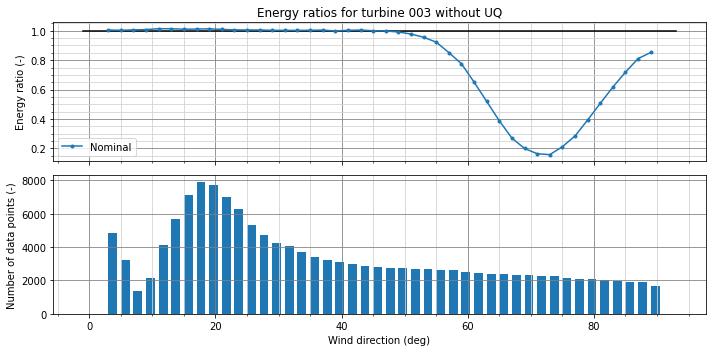

In [14]:
# Get energy ratio without uncertainty quantification
tt = 3
era.get_energy_ratio(
    test_turbines=[tt],
    wd_step=2.0,
    ws_step=1.0,
    wd_bin_width=3.0,
)
fig, ax = era.plot_energy_ratio()
ax[0].set_title("Energy ratios for turbine %03d without UQ" % tt)
plt.tight_layout()

## Prototype the function

floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.
floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.
floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.
floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.
floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 fo

floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.
floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.
floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.
floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 for horizontal plane.
floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 90.0 for horizontal plane.
INFO:floris.tools.floris_interface.FlorisInterface:Default to hub height = 90.0 fo

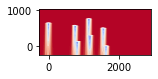

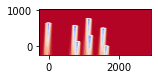

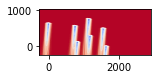

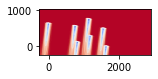

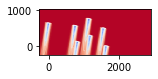

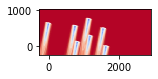

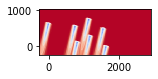

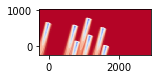

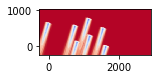

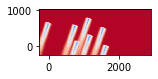

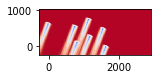

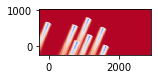

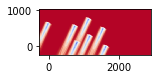

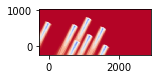

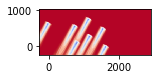

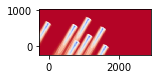

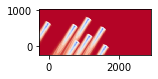

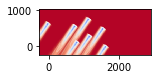

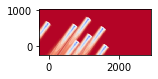

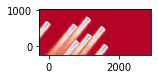

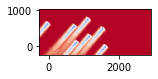

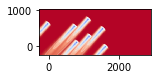

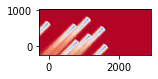

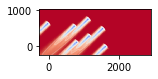

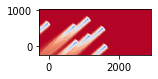

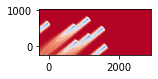

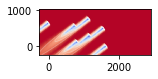

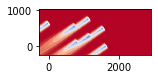

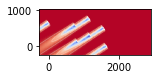

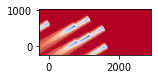

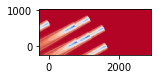

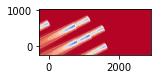

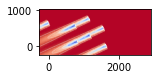

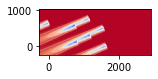

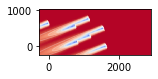

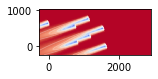

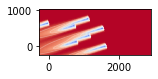

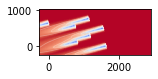

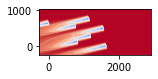

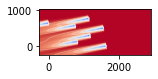

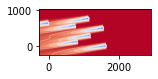

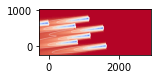

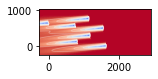

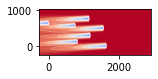

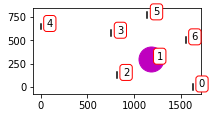

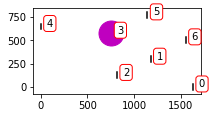

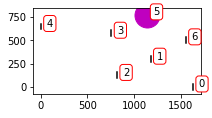

In [15]:
def table_analysis(df_list, name_list, t_list, wd_bins, ws_bins, filename, fi_for_layout=None):
    
    
    # Save some useful info
    header_row = 2
    first_data_row = header_row + 1
    first_data_col = 1
    
    # If t_list is none put in all possible turbines
    # TODO
    
    # Save the basename
    basename = name_list[0]
    
    # Stitch the dataframes together
    df_full = pd.DataFrame()
    for dfx, namex in zip(df_list, name_list):
        df_temp = dfx.copy()
        df_temp['name'] = namex
        df_full = df_full.append(df_temp)
        
    
    # Cut wd and ws into bins
    df_full['wd_bin'] = pd.cut(df_full.wd,wd_bins)
    df_full['ws_bin'] = pd.cut(df_full.ws,ws_bins)
    
    # Save the original bins
    df_save_bin = df_full[['wd_bin','ws_bin']]
    
    # Drop out of range
    df_full = df_full.dropna(subset=['wd_bin','ws_bin'])
    
    # Sort by bins
    df_full = df_full.sort_values(['name','wd_bin','ws_bin'])
    
    # Add a bin count column
    df_full['bin_count'] = 1
    
    # So we don't lose precision multiply TI by 100
    df_full['ti'] = 100 * df_full['ti']
    
    # Convert all to sums and means
    df_group = df_full.groupby(['wd_bin','ws_bin','name']).agg([np.sum,np.mean])
    
    # Flatten the columns
    df_group.columns = ["_".join(c) for c in df_group.columns]
    
    # Spin the name out to the columns
    df_group = df_group.unstack()
    
    # Flatten the columns
    df_group.columns = ["_".join(c) for c in df_group.columns]
    
    # Round the numerical columns to one decimal place
    df_group = df_group.round(1)
    
    # Reset the index
    df_group = df_group.reset_index()
    
    # Put together the final table
    df_table = df_group[['wd_bin','ws_bin']].copy()
    
    # Add the bin counts, mean wind speeds, and reference power
    for n in name_list:
        df_table['bin_count_sum_%s' % n] = df_group['bin_count_sum_%s' % n]
    for n in name_list:
        df_table['ws_mean_%s' % n] = df_group['ws_mean_%s' % n]
    for n in name_list:
        df_table['ti_mean_%s' % n] = df_group['ti_mean_%s' % n] / 100. # Back to decimal
    for n in name_list:
        df_table['ref_energy_%s' % n] = df_group['pow_ref_sum_%s' % n]
    
    # Add an empty column
    df_table['___'] = None
    
    # Add the rest via turbine
    for t in t_list:
        for n in name_list:

            # Add the energy
            df_table['energy_%03d_%s' % (t,n)] = df_group['pow_%03d_sum_%s' % (t,n)]
            
            # Add the energy ratio
            df_table['er_%03d_%s' % (t,n)] = np.round(df_table['energy_%03d_%s' % (t,n)] / df_table['ref_energy_%s' % n],3)
    
            # Only do this if not first
            if not n == name_list[0]:
                # Add the change in energy ratio from baseline (whichever name is first)
                df_table['er_change_%03d_%s' % (t,n)] = np.round(1 * (df_table['er_%03d_%s' % (t,n)] - df_table['er_%03d_%s' % (t,basename)]) / df_table['er_%03d_%s' % (t,basename)],3) 
    
        # Add an empty column
        df_table['___%d' % t] = None
        
    
    
    # Add the totals by direction
    df_table_final = pd.DataFrame()
    for wd_bin in df_table.wd_bin.unique():
        df_sub_pre = df_table[df_table.wd_bin == wd_bin]
        
        # Make a new df which is a sum of the other
        df_sub = df_sub_pre.append(df_sub_pre.sum(numeric_only=True), ignore_index=True)#.to_frame()
        
        # Go through the columns of this frame and fix the last row
        last_row = df_sub.shape[0] -1
        
        # Fix ws and wd
        df_sub.loc[last_row,'wd_bin'] = df_sub.loc[last_row-1,'wd_bin']
        df_sub['ws_bin'] = df_sub['ws_bin'].astype(str)
        df_sub.loc[last_row,'ws_bin'] = 'TOTALS'
        
        # Correct ws and ti to be a mean
        # And in case of TI, divide by 100 to go back to decimal
        for n in name_list:
            df_sub.loc[last_row,'ws_mean_%s' % n] = np.round(np.sum(df_sub_pre['bin_count_sum_%s' % n] * df_sub_pre['ws_mean_%s' % n]) / df_sub_pre['bin_count_sum_%s' % n].sum(),1)
            df_sub.loc[last_row,'ti_mean_%s' % n] = np.round(np.sum(df_sub_pre['bin_count_sum_%s' % n] * df_sub_pre['ti_mean_%s' % n]) / df_sub_pre['bin_count_sum_%s' % n].sum(),3)
            

        # Correct the energy ratios
        for t in t_list:
            for n in name_list:
                
                # Recompute the energy ratio (overwrite the sum)
                df_sub['er_%03d_%s' % (t,n)] = np.round(df_sub['energy_%03d_%s' % (t,n)] / df_sub['ref_energy_%s' % n],3)
                # df_sub.loc[last_row,'er_%03d_%s' % (t,n)] = df_sub.loc[last_row,'energy_%03d_%s' % (t,n)] / df_sub.loc[last_row,'ref_energy_%s' % n]
        
                # Only do this if not first
                if not n == name_list[0]:
                    # Recompute the change in energy ratio (overwrite the sum)
                    df_sub['er_change_%03d_%s' % (t,n)] = np.round(1 * (df_sub['er_%03d_%s' % (t,n)] - df_sub['er_%03d_%s' % (t,basename)]) / df_sub['er_%03d_%s' % (t,basename)],3) 
        
        # Add an empty row
        df_sub = df_sub.append(pd.DataFrame([[''] * len(df_sub.columns)], columns=df_sub.columns))
        
        # Append to the final
        df_table_final = df_table_final.append(df_sub)
        
    
    # Write out the dataframe with xslxwriter
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    df_table_final.to_excel(writer , index=False, sheet_name= 'results',startcol=first_data_col,startrow=header_row)
    workbook = writer.book
    worksheet = writer.sheets['results']
    
    # Set some formatting
    
    # Make change and TI into a percentage
    # Adding percentage format.
    fmt_rate = workbook.add_format({
     "num_format" : '%0.0' , "bold" : False
    })
    cols = df_table_final.columns
    change_list = [i for i in range(len(cols)) if ('change' in cols[i]) or ('ti_' in cols[i])]
    for c in change_list:
        worksheet.set_column(c+first_data_col,c+first_data_col,10,fmt_rate)
        
    # Make the seperator columns very narrow and black
    fmt_black = workbook.add_format({
     "fg_color" : '#000000'
    })
    change_list = [i for i in range(len(cols)) if '___' in cols[i]]
    for c in change_list:
        worksheet.set_column(c+first_data_col,c+first_data_col,1,fmt_black)
        
    # Add data bars to the bins counts
    change_list = [i for i in range(len(cols)) if 'count' in cols[i]]
    for c in change_list:
        worksheet.conditional_format(first_data_row,c+first_data_col,df_table_final.shape[0]+first_data_row,c+first_data_col, {'type': 'data_bar','max_value':100})
        
    # Add color to the change columns
    change_list = [i for i in range(len(cols)) if 'change' in cols[i]]
    for c in change_list:
        worksheet.conditional_format(first_data_row,c+first_data_col,df_table_final.shape[0]+first_data_row,c+first_data_col, {'type': 'data_bar','bar_axis_position': 'middle','bar_negative_border_color_same': True})
    
    # Add color to energy ratios
    change_list = [i for i in range(len(cols)) if ('er_' in cols[i]) and not ('change' in cols[i])]
    for c in change_list:
        worksheet.conditional_format(first_data_row,c+first_data_col,df_table_final.shape[0]+first_data_row,c+first_data_col, {'type': '3_color_scale',
                                                                     'min_value': 0.25,
                                                                     'min_type':'num',
                                                                     'max_value': 1.0,
                                                                     'max_type':'num'})
    
    
    # Header
    # Adding formats for header row.
    fmt_header = workbook.add_format({
     'bold': True,
     'text_wrap': True,
     'valign': 'top',
     'fg_color': '#5DADE2',
     'font_color': '#FFFFFF',
     'border': 1})
    for col , value in enumerate(df_table_final.columns.values):
         worksheet.write(header_row, col+first_data_col, value, fmt_header)
            
            
    # If an fi is provided, use it to make layout images to help with directions of things
    if fi_for_layout is not None:
        
        # Use FI to show the direction
        
        # Make that first colum wide
        worksheet.set_column('A:A', 30)
        
        #check image folder
        if not os.path.exists('images'):
            os.makedirs('images')
            
        # For each bin were checking make an image
        sort_df = df_save_bin.sort_values(['wd_bin','ws_bin']).dropna()
        num_ws_bin = len(sort_df.ws_bin.unique())
        for wdb_idx, wdb in enumerate(sort_df.wd_bin.unique()):
            wd_arrow = wdb.mid # Put arrow in middle of bin
            fig, ax = plt.subplots(figsize=(2,2))
            fi.reinitialize_flow_field(wind_direction=wd_arrow,wind_speed=8.)
            fi.calculate_wake()
            hor_plane = fi.get_hor_plane()
            wfct.visualization.visualize_cut_plane(hor_plane, ax=ax)
            im_name = os.path.join('images','wd_%03d.png' % wd_arrow)
            fig.savefig(im_name,bbox_inches='tight')
            
            # Insert the figure
            worksheet.insert_image(first_data_row + wdb_idx * (num_ws_bin + 2),0, im_name)
            
        # Next use FI to indicate the turbine
        
        # Make the first row bigger
        worksheet.set_row(0, 120)
        
        # Get a list of blank columns indicating turbine starts
        blank_cols = [i for i in range(len(cols)) if '___' in cols[i]]
        for t_idx, t in enumerate(t_list):
            
            # Plot the layout
            fig, ax = plt.subplots(figsize=(3,2))
            fi.vis_layout(ax=ax)
            ax.plot(fi.layout_x[t],fi.layout_y[t],'mo',ms=25)
            im_name = os.path.join('images','layout_%03d.png' % t)
            fig.savefig(im_name,bbox_inches='tight')
            
            # Find the column
            bc = blank_cols[t_idx]
            worksheet.insert_image(0,bc+1, im_name)
            
    
    # Freeze the panes
    worksheet.freeze_panes(first_data_row,first_data_col)
    
    writer.save()
    

# 1 df example    
# table_analysis([df],['base'],[3,5], wd_bins = [30,32,34], ws_bins = np.arange(5,10,1), filename='test_file.xlsx')

# 2 df example (as in energy ratio example)
df2 = df.copy()
df2['wd'] = wrap_360(df2['wd'] + 0.0)
table_analysis([df, df2],['base','con'],[1,3,5], wd_bins = np.arange(0,90,2), ws_bins = np.arange(5,11,1), filename='test_file_2.xlsx', fi_for_layout=fi)